## QKMTuner: A Hyperparameter Optimization Pipeline

In the previous section we observed that many hyperparameters are involved when building a quantum kernel method. Let's differentiate between quantum and classical hyperparameters.

"Quantum hyperparameters":
- encoding circuit in general
    - num_qubits
    - num_layers
- feature_range for data preprocessing (or bandwidth)
- $k$-RDM and or choice of measurement operator in PQK approach

"Classical hyperparameters":
- QKRR: Regularization parameter $\alpha$
- QSVR: Regularization parameters $C$ and $\epsilon$
- outer_kernel hyperparameters, e.g., $\gamma$ in gaussian kernel and $\nu$ in Matérn kernel

As in classical ML, finding proper hyperparameters for a ML model for a given dataset is a challenging and in general computationally expensive task. The same transfers to QML. To adress this problem we developed a hyperparameter optimization pipeline for quantum kernel methods (QSVC, QSVR and QKRR) - <b>QKMOptuna</b> - which is based on sQUlearn and on Optuna -- a hyperparameter optimization framework. It features an imperative, *define-by-run* style user API and thus it allows for dynamically constructing search spaces for the hyperparameters. In QKMOtuna we particularly use 
    
- sQUlearn's and Optuna's compatibility with scikit-learn
- Optuna's efficient state-of-the-art optimization algorithms for sampling hyperparameters
- Optunas quick visualization tools

An schematic overview of the QKMOptuna implemantation and it's functionalities is given in Fig. 6.

<center>

<img src="./schematic.png" alt="QKMTuner" width=1000>


*Figure 6: Schematic illustration of our QKMTuner hyperparameter optimization pipeline*
</center>

### Find a best quantum kernel model

To find the best hyperparameters for a quantum kernel model for a given encoding circuit, QKMOptuna provides the evaluate_grid() method, which searches for

- optimal num_qubits and num_layers (within given boundaries for the corresponding search space)
- for given preprocessing method, optimize configuration settings (i.e., e.g., feature_range) for rescaling features
- optimal kernel algorithm hyperparameters (e.g., $C$ and $\epsilon$ for QSVR)
- optimal kernel hyperparameters (e.g., $\gamma$ for gaussian kernel)

#### Imports and data loading

In [1]:
import os
import sys
import joblib
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from optuna.samplers import TPESampler

sys.path.append("./../src/")
from qkm_tuner import QKMTuner

c:\Users\jsl\Documents\Code\GitHubProjects\QKMTuner\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: attempted relative import with no known parent package

In [7]:
# load 1D-PEC H adsorption data for alpha structure
file_1D_alpha = './data/alpha-potential_curve.xlsx'
data_alpha = get_1D_pes_from_xls(file_1D_alpha)

# restrict ourselves to on-top1 configuration
R_ontop1 = data_alpha[0][:,0]
E_ontop1 = data_alpha[0][:,1]

# perform train-test split
Rtrain, Rtest, Etrain, Etest = train_test_split(
    R_ontop1,
    E_ontop1,
    test_size=0.2,
    random_state=43
)
Rtrain = Rtrain.reshape(-1,1)
Rtest = Rtest.reshape(-1,1)
Etrain = Etrain.reshape(-1,1)
Etest = Etest.reshape(-1,1)

#### How to set up the method

Within this simulation we use sQUlearn's default PQK within a QSVR. For the sake of demonstration purposes we restrict ourselves to only evaluating the best model for the YZ_CX_EncodingCircuit. The following hyperparameters are optimized:

- min_range and max_range defining the feature_range in MinMaxScaler(feature_range=(min_range, max_range)) used for feature rescaling as well as therein we should use clip=True/False
- num_qubits of YZ_CX_EncodingCircuit
- num_layers of YZ_CX_EncodingCircuit
- gamma of outer_kernel="gaussian"
- epsilon and C, i.e. the QSVR regularization parameters

Futher one can specify:

- the boundaries of Optuna's hyperparameter search space (num_qubits_max and num_layers_max), 
- use different specifications of the PQKs (measurement and outer_kernel)
- optuna_sampler and optuna_pruner

In [33]:
# Define QKMoptuna instance
qkm_opt_inst = QKMOptuna(
    xtrain = Rtrain,
    xtest = Rtest,
    ytrain = Etrain,
    ytest = Etest,
    scaler_method = MinMaxScaler(),
    optimize_scaler = True,
    label_scaler = MinMaxScaler(feature_range=(0,1)),
    quantum_kernel = "PQK",
    quantum_kernel_method = "QSVR",
    executor=Executor("pennylane"),
    parameter_seed = 0
)

# Define encoding circuits for which one wants to compute the best models
encoding_circuits = [YZ_CX_EncodingCircuit]
# Call QKMOptuna's evalate_best_model() method and define parameters as desired
qkm_opt_inst.evaluate_best_model(
    encoding_circuits=encoding_circuits,
    measurement = "XYZ",
    outer_kernel = "gaussian",
    num_qubits_max = 10,
    num_layers_max = 10,
    optuna_sampler = TPESampler(seed=0),
    optuna_pruner = None, 
    n_trials = 100,
    outdir = './results_demo_evaluate_best_model/',
    file_identifier = '1D_H_adsorption_PEC_alpha_ontop1'
)

c:\Users\jsl\Documents\Code\CCI-GitLab-Repo_Quantum\aquas\demonstrator_aquas_meeting_2024-05-13\pipeline\pipeline_modified.py:121: UserWarning:

Optuna does not support saving/reloading across different Optuna versions with pickle.
            Thus, make sure to pip install the same versions or consider using RDBs to 
            save/reload a study accross different Optuna versions, cf.
            https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/001_rdb.html#rdb

[I 2024-05-08 12:50:00,825] A new study created in memory with name: optuna_study_evaluate_best_model_QSVR_PQK_YZ_CX_EncodingCircuit_1D_H_adsorption_PEC_alpha_ontop1
[I 2024-05-08 12:50:07,593] Trial 0 finished with value: 0.5486497005244173 and parameters: {'num_qubits': 6, 'num_layers': 4, 'min_range': -0.6239778297350675, 'max_range': 0.8559005023838371, 'clip': False, 'C': 86.7530797689978, 'epsilon': 0.10615904599004, 'gamma': 605.3082080079017}. Best is trial 0 with value: 0.5486497005244173.
[I 2024-05-08 1

The evaluate_best_model() method of QKMOptuna automatically saves the following intermediate and final simulation results:

- For each EncodingCircuit in the list of encoding_circuits, we save the optuna study object to a *.pkl-file
- For each EncodingCircuit in the list of encoding_circuits, the optimal circuits out of the optuna study is saved to a *.pkl-file
- The final summary is saved as *.csv file, which contains, for each EncodingCircuit:
    
    - best_params (i.e. num_qubits, num_layers, etc.) determined within optuna optimization
    - best_trial (optuna object to resume study)
    - best_obj_val
    - best_feature_range
    - ktrain
    - ktesttrain
    - ypred_train
    - ypred_test
    - mse_train
    - rmse_train
    - mae_train
    - r2_train
    - mse_test
    - rmse_test
    - mae_test 
    - r2_test

For classifications tasks we use accuracy_score, roc_auc_score and f1_score instead.

This is managed within two directories, which were also created by the previous simulation. Take a closer look into their content

In [37]:
print("'/cache_optuna_studies_evaluate_best_model/' contains: ", os.listdir("./results_demo_evaluate_best_model/cache_optuna_studies_evaluate_best_model") )
print("'/results_evaluate_best_model/' contains: ", os.listdir("results_demo_evaluate_best_model/results_evaluate_best_model/"))

'/cache_optuna_studies_evaluate_best_model/' contains:  ['optimal_circuit_from_optuna_study_evaluate_best_model_QSVR_PQK_YZ_CX_EncodingCircuit_1D_H_adsorption_PEC_alpha_ontop1.pkl', 'optuna_study_evaluate_best_model_QSVR_PQK_YZ_CX_EncodingCircuit_1D_H_adsorption_PEC_alpha_ontop1.pkl']
'/results_evaluate_best_model/' contains:  ['results_evaluate_best_model_study_QSVR_PQK_1D_H_adsorption_PEC_alpha_ontop1.csv']


This means .pkl-files are created in a cache directory containing the optimal encoding circuit as well as the complete optuna study itself from which the best model configurations can be extracted. Moreover the optuna study pickle can be used to resume the study and start a new study from there. 

#### Anaylzing the results

We can investigate the importance of hyperparameters by loading the *.pkl-file containing the corresponding Optuna study object and subsequently use Optuna's visualization tools.

Recall that within this simulation we optimized the following hyperparameters:

- min_range and max_range defining the feature_range in MinMaxScaler(feature_range=(min_range, max_range)) used for feature rescaling as well as therein we should use clip=True/False
- num_qubits of YZ_CX_EncodingCircuit
- num_layers of YZ_CX_EncodingCircuit
- gamma of outer_kernel="gaussian"
- epsilon and C, i.e. the QSVR regularization parameters

In [44]:
file_study = "./results_demo_evaluate_best_model/cache_optuna_studies_evaluate_best_model/optuna_study_evaluate_best_model_QSVR_PQK_YZ_CX_EncodingCircuit_1D_H_adsorption_PEC_alpha_ontop1.pkl"
study = joblib.load(file_study)

In [45]:
from optuna.visualization import plot_param_importances
plot_param_importances(study)

For the sake of generating a large database of quantum kernel experiments, all final results are saved as *.csv file.

In [47]:
df = pd.read_csv("./results_demo_evaluate_best_model/results_evaluate_best_model/results_evaluate_best_model_study_QSVR_PQK_1D_H_adsorption_PEC_alpha_ontop1.csv")
df

,Unnamed: 0,encoding_circuit,best_params,best_trial,best_obj_val,best_feature_range,ktrain,ktesttrain,ypred_train,ypred_test,mse_train,rmse_train,mae_train,r2_train,mse_test,rmse_test,mae_test,r2_test
0,0,YZ_CX_EncodingCircuit,"{'num_qubits': 1, 'num_layers': 2, 'min_range'...","FrozenTrial(number=51, state=TrialState.COMPLE...",0.999996,"(-0.0761932689255125, 1.493420842475225)",[[1.00000000e+00 1.34903672e-04 6.93052636e-10...,[[3.41623161e-09 3.47830962e-07 2.84853776e-03...,[[-205.44251779]\n [-207.41105589]\n [-206.586...,[[-206.3208708 ]\n [-207.9922776 ]\n [-207.043...,0.000007,0.002686,0.002274,0.999997,0.000007,0.002711,0.00235,0.999995


#### Run KTA within the pipeline

We can use the previously determined best quantum kernel model based on the YZ_CX_EncodingCircuit to optimize the trainable parameters in this feature map using KTA. To this end, we use the current state of the qkm_opt_inst

In [50]:
from squlearn.optimizers import Adam
adam = Adam(options={"maxiter": 50, "lr":0.01})
qkm_opt_inst.run_quantum_kernel_optimization(adam)

[0.80132351 0.88272066 0.21827963 0.28200936]


In [51]:
qkm_opt_inst.evaluate_model_from_optimized_qkernel(n_trials=10, outdir='./results_demo_evaluate_best_model/', file_identifier='1D_H_adsorption_PEC_alpha_ontop1_KTA')

[I 2024-05-08 16:53:30,956] A new study created in memory with name: no-name-69fe261d-8cfc-4e16-bce8-c86e5f88001b
[I 2024-05-08 16:53:31,540] Trial 0 finished with value: 0.999993775609448 and parameters: {'C': 7773.657555376826, 'epsilon': 3.691684401357102e-08, 'gamma': 56.34711619484347}. Best is trial 0 with value: 0.999993775609448.
[I 2024-05-08 16:53:31,840] Trial 1 finished with value: 0.9932753168660305 and parameters: {'C': 16494.482339392038, 'epsilon': 0.01092529121222421, 'gamma': 19.14013680197427}. Best is trial 0 with value: 0.999993775609448.
[I 2024-05-08 16:53:33,761] Trial 2 finished with value: 0.9987842239323127 and parameters: {'C': 436.1404865562257, 'epsilon': 3.090053349179177e-08, 'gamma': 1.2769632527667107}. Best is trial 0 with value: 0.999993775609448.
[I 2024-05-08 16:53:34,053] Trial 3 finished with value: 0.7337997409725026 and parameters: {'C': 0.40367307673696384, 'epsilon': 0.06270123705467934, 'gamma': 56.731080556541436}. Best is trial 0 with valu

In [52]:
df_opt =  pd.read_csv("./results_demo_evaluate_best_model/results_evaluate_model_from_optimized_qkernel/results_evaluate_model_from_optimized_qkernel_QSVR_PQK_1D_H_adsorption_PEC_alpha_ontop1_KTA.csv")
df_opt

,Unnamed: 0,optimal_parameters,ktrain_opt_only,ktesttrain_opt_only,best_optuna_params_new,best_feature_range,ktrain_opt_and_optuna,ktesttrain_opt_and_optuna,mse_test_opt_only,rmse_test_opt_only,mae_test_opt_only,r2_test_opt_only,mse_test_opt_and_optuna,rmse_test_opt_and_optuna,mae_test_opt_and_optuna,r2_test_opt_and_optuna
0,0,[0.80132351 0.88272066 0.21827963 0.28200936],[[1.00000000e+00 1.34903672e-04 6.93052636e-10...,[[3.41623161e-09 3.47830962e-07 2.84853776e-03...,"{'C': 795.5458990026285, 'epsilon': 5.38767299...","(-0.0761932689255125, 1.493420842475225)",[[1.00000000e+00 1.91419985e-03 3.69118820e-07...,[[1.13169484e-06 2.90997058e-05 1.63040896e-02...,0.000007,0.002711,0.00235,0.999995,0.000005,0.002314,0.001903,0.999997


### Sophisticated grid search

In order to systematically analyze and compare quantum kernel methods as well as providing general design advices, ideally an extensive quantum kernel study is required, which considers many different datasets and different encoding circuits - in the spirit of Ref. [5]. To this end, QKMOptuna provides the evaluate_grid() method, which 

- for each circuit within a list of encoding_circuits sets up a predefined grid to consider different num_qubits and num_layer configurations and for each configuration performs a hyperparameter search to determine

    - hyperparameters of the quantum kernel method 
    - hyperparameters of PQKs (e.g. $\gamma$ for gaussian kernel)
    - for given feature preprocessing routine (e.g. MinMaxScaler) optimize it's configuration (i.e., e.g. feature_range)

The evaluate_grid() method automatically saves the followig intermediate and final results:

- Optuna study object as *.pkl file for each encoding circuit and each (num_qubits, num_layers)-configuration
- Best trial optuna object as *.pkl file for each encoding circuit within given (num_qubits, num_layers)-grid corresponding to setting with highest R2-score on test data
- Accordingly, corresponding EncodingCircuit sQUlearn object as *.pkl-file
- Kernel matrices for each encoding circuit and each (num_qubits, num_layers)-configuration after optuna optimization in a *csv-file
- A final summary is saved as *.csv file, which contains, for each EncodingCircuit:

    - best_param_mat
    - best_trial_mat
    - best_objective_value_mat
    - feature_range_mat
    - mse_train_mat 
    - rmse_train_mat
    - mae_train_mat
    - r2_train_mat
    - mse_test_mat
    - rmse_test_mat
    - mae_test_mat
    - r2_test_mat

For classifications tasks we use accuracy_score, roc_auc_score and f1_score instead

To use the evaluate_grid() method of the QKMOptuna pipeline, we just provide the corresponding code but, for the sake of runtime, do not execute them. We would rather like to show how to use and analyze the generated results.

#### Results: 1D H-adsorption PEC (alpha, on-top1)

Here, we use the 1D H-adsorption PEC dataset for alpha-ontop1 configuration (cf. Fig. 4) and execute the evaluate_grid() method for both FQK and PQK using QKRR.

##### Imports and data loading

In [11]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from squlearn import Executor
from squlearn.encoding_circuit import YZ_CX_EncodingCircuit

from pipeline.tools import get_1D_pes_from_xls

For the sake of demonstration purposes, in the following we restrict ourselves to the YZ_CX_EncodingCircuit only. So does the following code snippet, which is given for FQK.

First we load the data

In [9]:
# load 1D-PEC H adsorption data for alpha structure
file_1D_alpha = './data/alpha-potential_curve.xlsx'
data_alpha = get_1D_pes_from_xls(file_1D_alpha)

# restrict ourselves to on-top1 configuration
R_ontop1 = data_alpha[0][:,0]
E_ontop1 = data_alpha[0][:,1]

# perform train-test split
Rtrain, Rtest, Etrain, Etest = train_test_split(
    R_ontop1,
    E_ontop1,
    test_size=0.2,
    random_state=43
)
Rtrain = Rtrain.reshape(-1,1)
Rtest = Rtest.reshape(-1,1)
Etrain = Etrain.reshape(-1,1)
Etest = Etest.reshape(-1,1)

##### How to set up the method

QKMOptuna is initilized such that 

- a given feature preprocessing is used and no optimization of the scaler is performed
- we further rescale the labels using MinMaxScaler()

Here one can also use different scalers for both features and labels and can additionally optimize the respective feature preproccesing method. Moreover, one can change the quantum_kernel and quantum_kernel_method parameters.

To finally call the evaluate_grid() method one has to specify the encoding_circuits upon which one builds a grid. This grid is defined by the layer_list and qubit list arguments. Beyond that, QKMOptuna allows for different PQK settings (i.e. differemt measurement and outer_kernel attributes).

For FQKs one merely has to change the quantum_kernel parameter in the code example below.

In [ ]:
# Define the QKMOptuna instance. 
qkm_inst = QKMOptuna(
    xtrain=Rtrain,
    xtest=Rtest,
    ytrain=Etrain,
    ytest=Etest,
    scaler_method=MinMaxScaler(feature_range=(-np.pi/2., np.pi/2.)), # use predfined scaler for features and do not optimize it
    optimize_scaler=False,
    label_scaler=MinMaxScaler(), # note, we rescale labels
    quantum_kernel="PQK",
    quantum_kernel_method="QKRR",
    executor=Executor("pennylane"),
    parameter_seed=0
)

# Define the grid search ranges
encoding_circuits = [YZ_CX_EncodingCircuit]
layer_list = [1,2,3,4,5,6,7,8]
qubit_list = [1,2,3,4,5,6,7,8]
# set up the evaluate_grid() method
qkm_inst.evaluate_grid(
    encoding_circuits=encoding_circuits,
    measurement="XYZ",
    outer_kernel="gaussian",
    qubits_list=qubit_list,
    layers_list=layer_list,
    optuna_sampler=TPESampler(seed=0),
    n_trials=50,
    outdir="./results_1D/",
    file_identifier="1d_h_adsorption_pec"
)

 The evalute_grid() method of QKMOptuna automatically saves many intermediate as well as final simulation results. This is useful for various post-processing analyses as well as for subsequent studies. Moreover, saving Optuna study objects allows to resume a study. The following shows the format of final simulation results and how to further process and analyze them.

In [14]:
df_1D_fqk_qkrr = pd.read_csv("results_1D/fqk_qkrr/results_evaluate_grid/results_evaluate_grid_study_QKRR_FQK_1d_h_adsorption_pec.csv")
df_1D_pqk_qkrr = pd.read_csv("results_1D/pqk_qkrr/results_evaluate_grid/results_evaluate_grid_study_QKRR_PQK_1d_h_adsorption_pec_alpha_ontop1.csv")
df_1D_fqk_qkrr

,Unnamed: 0,encoding_circuit,best_trial_mat,best_objective_value_mat,feature_range_mat,mse_train_mat,rmse_train_mat,mae_train_mat,r2_train_mat,mse_test_mat,rmse_test_mat,mae_test_mat,r2_test_mat
0,0,YZ_CX_EncodingCircuit,"[[FrozenTrial(number=38, state=TrialState.COMP...",[[0.15851851 0.37109932 0.44075027 0.27201005 ...,"[[(-1.5707963267948966, 1.5707963267948966)\n ...",[[1.85160870e+00 1.26430701e+00 1.18339727e+00...,[[1.36073829e+00 1.12441407e+00 1.08784065e+00...,[[6.64082207e-01 7.87502924e-01 6.91405141e-01...,[[0.15449832 0.4226784 0.45962429 0.31818107 ...,[[1.32794490e+00 1.00226454e+00 8.66636022e-01...,[[1.15236492e+00 1.00113163e+00 9.30932877e-01...,[[6.57682739e-01 7.27036397e-01 6.47748563e-01...,[[0.18396243 0.3840968 0.46744209 0.4027917 ...


##### Analysis

In [17]:
from pipeline.tools import matrix_of_best_param_dicts_to_numpy_tensor, pandas_matrix_to_numpy_array

Let us plot the results corresponding to this exemplatory study based on the YZ_CX_EncodingCircuit for FQKs

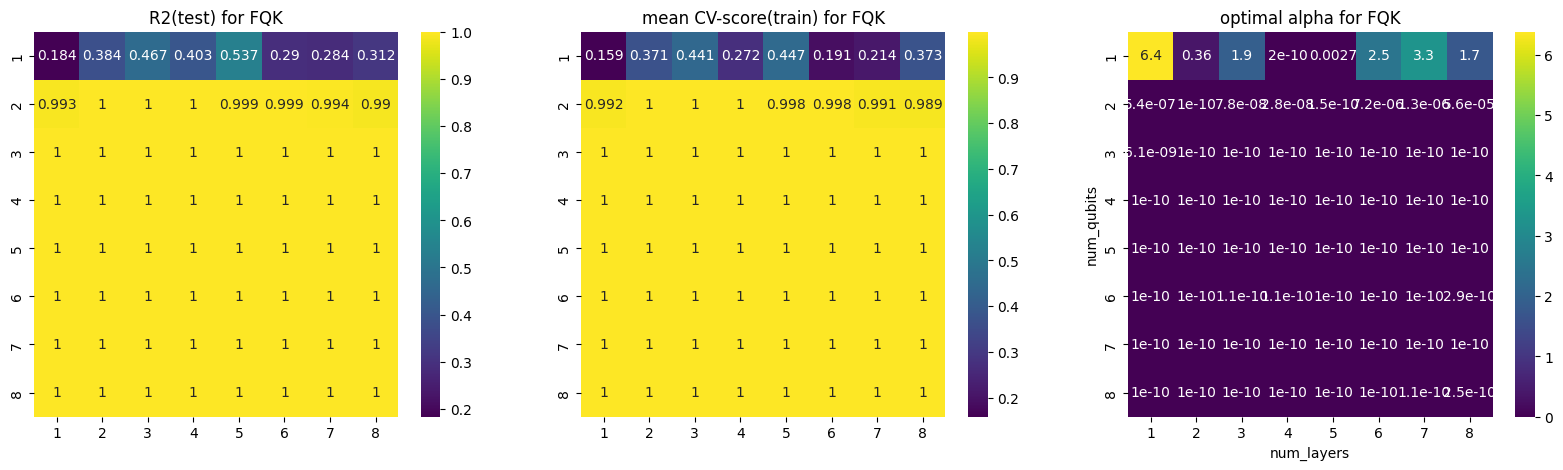

In [18]:
qubit_list = list(np.arange(1,9))
layer_list = list(np.arange(1,9))


mat_r2_fqk = pandas_matrix_to_numpy_array(df_1D_fqk_qkrr, 0, "r2_test_mat", qubit_list, layer_list)
mat_best_obj_fqk = pandas_matrix_to_numpy_array(df_1D_fqk_qkrr, 0, "best_objective_value_mat", qubit_list, layer_list)
mat_alpha_fqk = matrix_of_best_param_dicts_to_numpy_tensor(df_1D_fqk_qkrr, 0, qubit_list, layer_list)[0, :, :]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
axes[0].set_title("R2(test) for FQK")
sb.heatmap(mat_r2_fqk, annot=True, xticklabels=layer_list, yticklabels=qubit_list, cmap='viridis', fmt='.3g', ax=axes[0])
axes[1].set_title("mean CV-score(train) for FQK")
sb.heatmap(mat_best_obj_fqk, annot=True, xticklabels=layer_list, yticklabels=qubit_list, cmap='viridis', fmt='.3g', ax=axes[1])
axes[2].set_title("optimal alpha for FQK")
sb.heatmap(mat_alpha_fqk, annot=True, xticklabels=layer_list, yticklabels=qubit_list, cmap='viridis', ax=axes[2])

plt.xlabel("num_layers")
plt.ylabel("num_qubits")
plt.show()

Now the same plots for PQK based on the YZ_CX_EncodingCircuit. Note that for PQKs we also optimize the gamma hyperparameter of the gaussian outer_kernel.

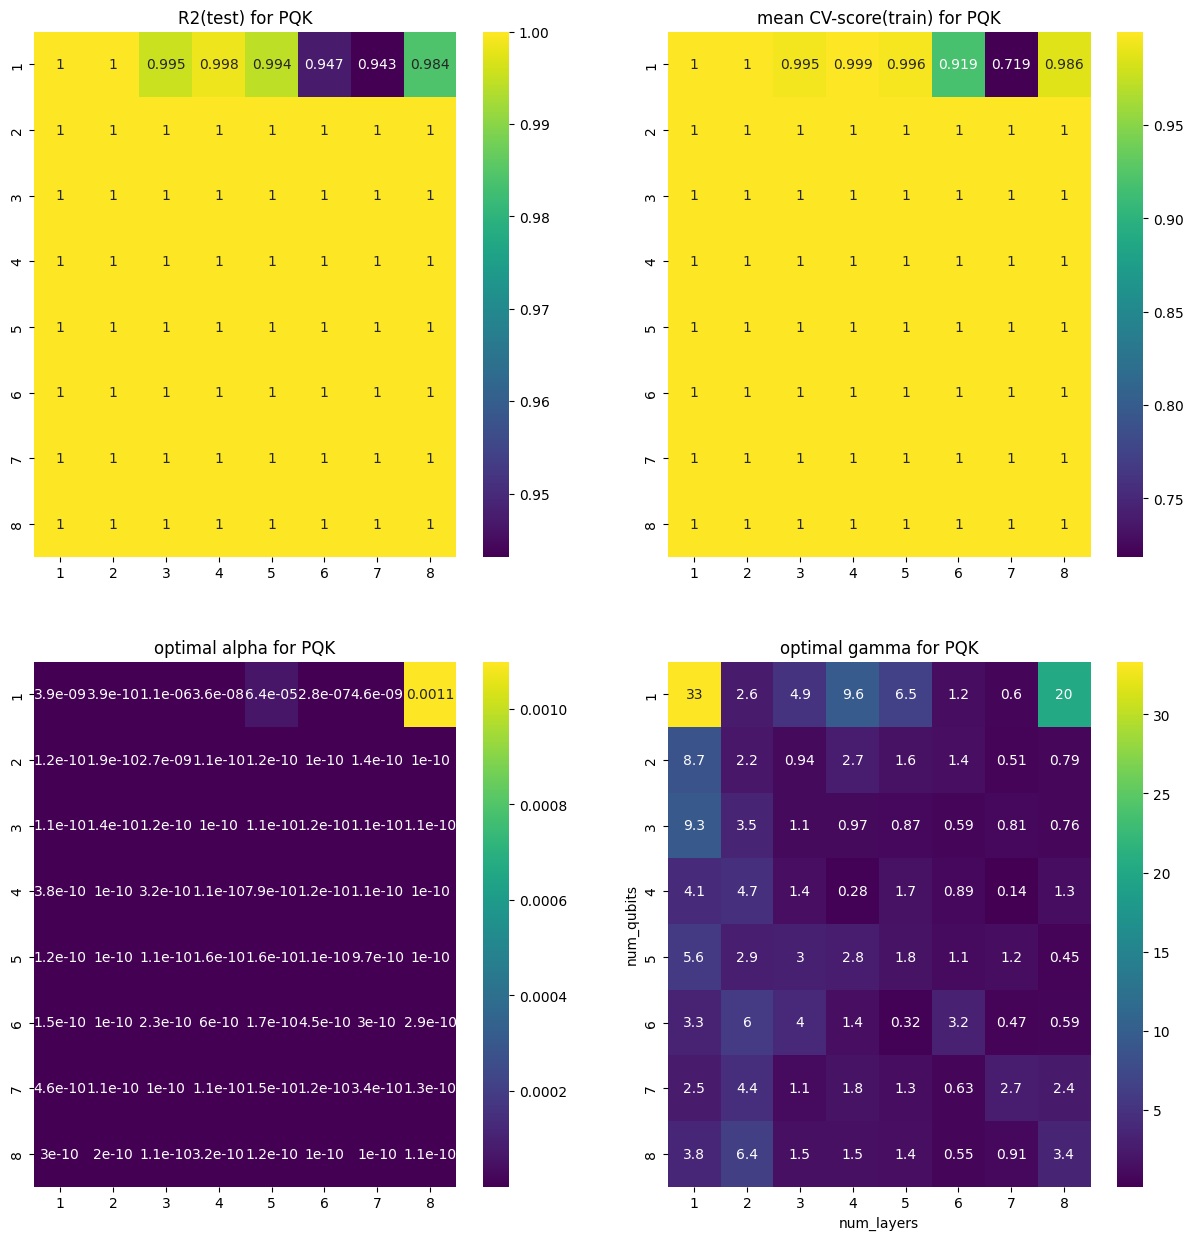

In [19]:
mat_r2_pqk = pandas_matrix_to_numpy_array(df_1D_pqk_qkrr, 0, "r2_test_mat", qubit_list, layer_list)
mat_best_obj_pqk = pandas_matrix_to_numpy_array(df_1D_pqk_qkrr, 0, "best_objective_value_mat", qubit_list, layer_list)
mat_alpha_pqk = matrix_of_best_param_dicts_to_numpy_tensor(df_1D_pqk_qkrr, 0, qubit_list, layer_list)[0, :, :]
mat_gamma_pqk = matrix_of_best_param_dicts_to_numpy_tensor(df_1D_pqk_qkrr, 0, qubit_list, layer_list)[1, :, :]

fig, axes_pqk = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
axes_pqk = axes_pqk.flatten()

axes_pqk[0].set_title("R2(test) for PQK")
sb.heatmap(mat_r2_pqk, annot=True, xticklabels=layer_list, yticklabels=qubit_list, cmap='viridis', fmt='.3g', ax=axes_pqk[0])
axes_pqk[1].set_title("mean CV-score(train) for PQK")
sb.heatmap(mat_best_obj_pqk, annot=True, xticklabels=layer_list, yticklabels=qubit_list, cmap='viridis', fmt='.3g', ax=axes_pqk[1])
axes_pqk[2].set_title("optimal alpha for PQK")
sb.heatmap(mat_alpha_pqk, annot=True, xticklabels=layer_list, yticklabels=qubit_list, cmap='viridis', ax=axes_pqk[2])
axes_pqk[3].set_title("optimal gamma for PQK")
sb.heatmap(mat_gamma_pqk, annot=True, xticklabels=layer_list, yticklabels=qubit_list, cmap='viridis', ax=axes_pqk[3])

plt.xlabel("num_layers")
plt.ylabel("num_qubits")
plt.show()

All in all these results suggest that the corresponding 1D PEC dataset is too simple to reasonably study quantum kernel methods systematically

##### Analyze the importance of hyperparameters

In [5]:
import joblib
from optuna.visualization import plot_param_importances

Analyze the hyperparameter importance only for PQK as within evaluate_grid() we only optimize $\alpha$ (the KRR regularization parameter) for FQK

In [3]:
# Load the optuna study object corresponding to the "optimal" (in the sensse of highest r2-score on test-data) quantum kernel model and the "optimal" encoding circuit
file_circ_opt = "./results_1D/pqk_qkrr/cache_optuna_studies_evaluate_grid/optimal/optimal_YZ_CX_EncodingCircuit_from_evaluate_grid_1d_h_adsorption_pec_alpha_ontop1.pkl"

circ_opt = joblib.load(file_circ_opt)
circ_opt.get_params()
print("The 'optimal' number of qubits here: num_qubits=", circ_opt.get_params()["num_qubits"])
print("The 'optimal' number of layers here: num_layers=", circ_opt.get_params()["num_layers"])

The 'optimal' number of qubits here: num_qubits= 4
The 'optimal' number of layers here: num_layers= 6


In [4]:
file_study_opt = "./results_1D/pqk_qkrr/cache_optuna_studies_evaluate_grid/optuna_study_evaluate_grid_QKRR_PQK_YZ_CX_EncodingCircuit_num_qubits4_num_layers6_1d_h_adsorption_pec_alpha_ontop1.pkl"
study_opt = joblib.load(file_study_opt)
plot_param_importances(study_opt)

#### Results: 2D H-adsorption PEC (H parallel to boron trigonal)

Here, we consider the dataset corresponding to the 2D-PES-plot in Fig. 5.

This last section indicates how one can use QKMOptuna to generate large quantum kernel studies over different datasets and different encoding circuits and how one can analyze corresponing results. Here, we want to investigate correlations between all classical and quantum hyperparameters. For the sake of simplicity let us restrict the correlation w.r.t model performance to r2 test score and only consider results from PQK simulations with QKRR

##### Imports and data loading

In [3]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from functools import partial 
from sklearn.model_selection import train_test_split
from optuna.samplers import TPESampler

from squlearn.encoding_circuit import YZ_CX_EncodingCircuit, HighDimEncodingCircuit, HubregtsenEncodingCircuit, ChebyshevPQC, ParamZFeatureMap

from pipeline.tools import get_2D_pes_from_xls

In [6]:
file_2D_trigonal = "./data/potential_surface.xlsx"
data_2D = get_2D_pes_from_xls(file_2D_trigonal)

x_2D = data_2D[3][:, 0:2]
E_2D = data_2D[3][:, 2]

R1_train, R1_test, E1_train, E1_test = train_test_split(
    x_2D,
    E_2D,
    test_size=0.2,
    random_state=43
)

##### How to set up the method

The code snippet below is just for demonstration purposes how to set up the method.

In [ ]:
qkm_inst = QKMOptuna(
    xtrain=R1_train,
    xtest=R1_test,
    ytrain=E1_train,
    ytest=E1_test,
    scaler_method=MinMaxScaler(feature_range=(-np.pi/2., np.pi/2.)), # use predfined scaler for features and do not optimize it
    optimize_scaler=False,
    label_scaler=MinMaxScaler(), # note, we rescale labels
    quantum_kernel="PQK",
    quantum_kernel_method="QKRR",
    executor=Executor("pennylane"),
    parameter_seed=0
)

encoding_circuits = [YZ_CX_EncodingCircuit, HighDimEncodingCircuit, HubregtsenEncodingCircuit, ChebyshevPQC, partial(ParamZFeatureMap, entangling=True)]
# Define the grid search ranges
layer_list = [1,2,3,4,5,6,7,8]
qubit_list = [2,4,6,8] # since dataset has two features we only consider even qubit numbers
qkm_inst.evaluate_grid(
    encoding_circuits=encoding_circuits,
    measurement="XYZ",
    outer_kernel="gaussian",
    qubits_list=qubit_list,
    layers_list=layer_list,
    optuna_sampler=TPESampler(seed=0),
    n_trials=50,
    outdir="./results_2D/pqk_qkrr/",
    file_identifier="2d_h_adsorption_pec_trigonal"
)

##### Analysis

The following dataframe shows the format of this final simulation results and how to further process and analyze them.

In [5]:
df_2D_pqk = pd.read_csv("results_2D/pqk_qkrr/results_evaluate_grid/results_evaluate_grid_study_QKRR_PQK_2d_h_adsorption_pec_trigonal.csv")
df_2D_pqk

,Unnamed: 0,encoding_circuit,best_trial_mat,best_objective_value_mat,feature_range_mat,mse_train_mat,rmse_train_mat,mae_train_mat,r2_train_mat,mse_test_mat,rmse_test_mat,mae_test_mat,r2_test_mat
0,0,YZ_CX_EncodingCircuit,"[[FrozenTrial(number=41, state=TrialState.COMP...",[[0.93057987 0.97516193 0.99729752 0.74317513 ...,"[[(-1.5707963267948966, 1.5707963267948966)\n ...",[[1.13469321e-03 3.77585721e-04 3.89293667e-08...,[[3.36852076e-02 1.94315651e-02 1.97305263e-04...,[[1.61201887e-02 6.23364876e-03 1.44226574e-04...,[[0.96770257 0.98925256 0.99999889 0.8856822 ...,[[1.86521090e-03 1.01474794e-03 1.21426636e-05...,[[4.31880875e-02 3.18551086e-02 3.48463249e-03...,[[2.24546055e-02 1.16265749e-02 1.35942370e-03...,[[0.95024733 0.9729326 0.99967611 0.77656365 ...
1,1,HighDimEncodingCircuit,"[[FrozenTrial(number=47, state=TrialState.COMP...",[[0.92226407 0.93496965 0.93787578 0.93371879 ...,"[[(-1.5707963267948966, 1.5707963267948966)\n ...",[[0.00110127 0.00122014 0.00106635 0.00104882 ...,[[0.03318532 0.03493049 0.03265497 0.03238552 ...,[[0.01226345 0.01298971 0.01107984 0.01105271 ...,[[0.96865403 0.96527048 0.96964795 0.97014678 ...,[[0.00285459 0.00247792 0.0023266 0.00242907 ...,[[0.05342834 0.04977871 0.04823486 0.04928555 ...,[[0.02978946 0.0239603 0.02438517 0.02608317 ...,[[0.9238567 0.93390392 0.93794018 0.93520706 ...
2,2,HubregtsenEncodingCircuit,"[[FrozenTrial(number=38, state=TrialState.COMP...",[[0.99999825 0.88706954 0.82321356 0.64731945 ...,"[[(-1.5707963267948966, 1.5707963267948966)\n ...",[[2.87948093e-10 2.12928530e-03 3.88891414e-03...,[[1.69690334e-05 4.61441795e-02 6.23611589e-02...,[[1.31205565e-05 1.76687992e-02 3.53299610e-02...,[[0.99999999 0.93939292 0.88930758 0.73302975 ...,[[1.43982604e-08 5.49464480e-03 3.86787806e-03...,[[1.19992752e-04 7.41258713e-02 6.21922669e-02...,[[3.90695253e-05 2.35973205e-02 3.90182893e-02...,[[0.99999962 0.85343575 0.89682816 0.69357551 ...
3,3,ChebyshevPQC,"[[FrozenTrial(number=44, state=TrialState.COMP...",[[0.80833342 0.85492075 0.90820873 0.69559686 ...,"[[(-1, 1) (-1, 1) (-1, 1) (-1, 1) (-1, 1) (-1,...",[[4.42256012e-03 3.41021307e-03 7.29622545e-04...,[[6.65023317e-02 5.83970296e-02 2.70115261e-02...,[[5.57173757e-02 4.92345572e-02 2.23730201e-02...,[[0.87411811 0.90293313 0.97923233 0.73327195 ...,[[4.48418532e-03 5.30888491e-03 8.41857754e-03...,[[0.06696406 0.0728621 0.09175281 0.10444241 ...,[[0.05503828 0.0503228 0.03157904 0.08177903 ...,[[0.88038877 0.85839071 0.77544272 0.70903406 ...
4,4,"ParamZFeatureMap, entangling=True","[[FrozenTrial(number=12, state=TrialState.COMP...",[[0.99986016 0.99985448 0.99969937 0.99977055 ...,"[[(-1, 1) (-1, 1) (-1, 1) (-1, 1) (-1, 1) (-1,...",[[2.99044798e-08 1.74105018e-07 2.02517787e-07...,[[1.72929118e-04 4.17258933e-04 4.50019763e-04...,[[1.36916736e-04 2.88539010e-04 3.28833714e-04...,[[0.99999915 0.99999504 0.99999424 0.99999972 ...,[[7.60537612e-07 6.47190381e-07 2.53627550e-06...,[[0.00087209 0.00080448 0.00159257 0.00046749 ...,[[4.84901649e-04 4.97119338e-04 8.81740725e-04...,[[0.99997971 0.99998274 0.99993235 0.99999417 ...


Extract r2_test_mat from the above dataframe for two encoding circuits and visualize them with a heatmap.

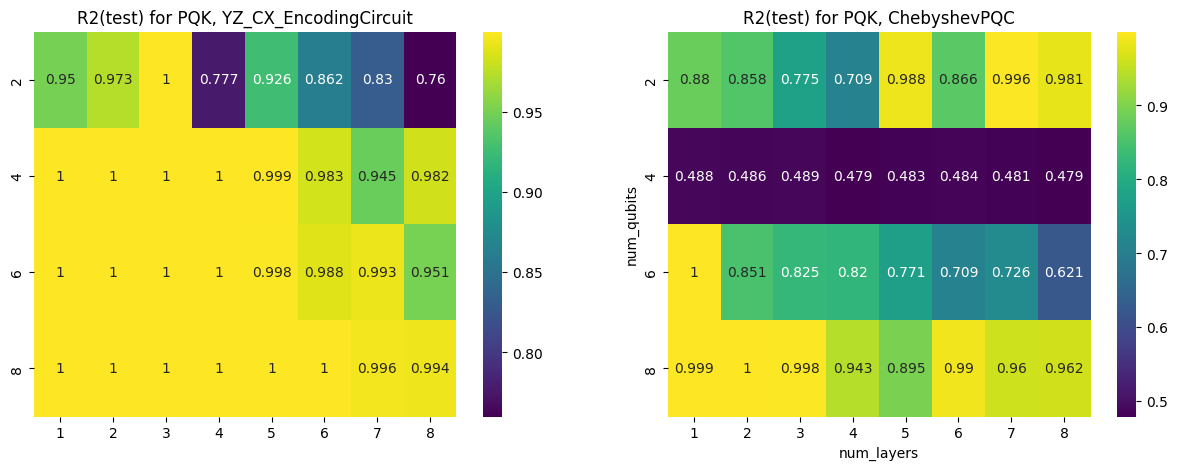

In [13]:
from pipeline.tools import pandas_matrix_to_numpy_array
qubit_list = [2,4,6,8]
layer_list = list(np.arange(1,9))

mat_r2_2D_pqk_yz_cx = pandas_matrix_to_numpy_array(df_2D_pqk, 0, "r2_test_mat", qubit_list, layer_list)
mat_r2_2D_pqk_cheb = pandas_matrix_to_numpy_array(df_2D_pqk, 3, "r2_test_mat", qubit_list, layer_list)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].set_title("R2(test) for PQK, YZ_CX_EncodingCircuit")
sb.heatmap(mat_r2_2D_pqk_yz_cx, annot=True, xticklabels=layer_list, yticklabels=qubit_list, cmap='viridis', fmt='.3g', ax=axes[0])
axes[1].set_title("R2(test) for PQK, ChebyshevPQC")
sb.heatmap(mat_r2_2D_pqk_cheb, annot=True, xticklabels=layer_list, yticklabels=qubit_list, cmap='viridis', fmt='.3g', ax=axes[1])

plt.xlabel("num_layers")
plt.ylabel("num_qubits")
plt.show()

This dataset appears more complex than the 1D one. Thus, it might be suitable for a more systematic analyis of quantum kernel methods.

##### Investigate correlations between classical & quantum hyperparameters and the R2-test-score

To this end, we compute correlation matrices for each of the encoding circuits given in the above dataframe and subsequently calculate the corresponding "mean correlation matrix". Note that for a proper investigation we should also consider the variance for each value.

In [15]:
from pipeline.tools import get_stacked_correlation_matrices

qubit_list = [2,4,6,8]
layer_list = list(np.arange(1,9))

correlation_matrices = get_stacked_correlation_matrices(df_2D_pqk, qubit_list, layer_list, correlation_method="pearson", target_object="r2_test_mat")
df_corr_mean = pd.DataFrame(np.mean(correlation_matrices, axis=0))

In [16]:
column_names = {0: "R2", 1: "num_qubits", 2: "num_layers", 3: "alpha", 4: "gamma"}
df_new = df_corr_mean.rename(columns=column_names, index=column_names)
df_new

,R2,num_qubits,num_layers,alpha,gamma
R2,1.000000,4.239380e-01,-5.906019e-02,-0.135760,0.183865
num_qubits,0.423938,1.000000e+00,2.237999e-17,-0.121728,-0.380380
num_layers,-0.059060,2.237999e-17,1.000000e+00,0.119921,0.012208
alpha,-0.135760,-1.217277e-01,1.199206e-01,1.000000,0.245516
gamma,0.183865,-3.803803e-01,1.220829e-02,0.245516,1.000000


Plot the mean correlation matrix

<Axes: >

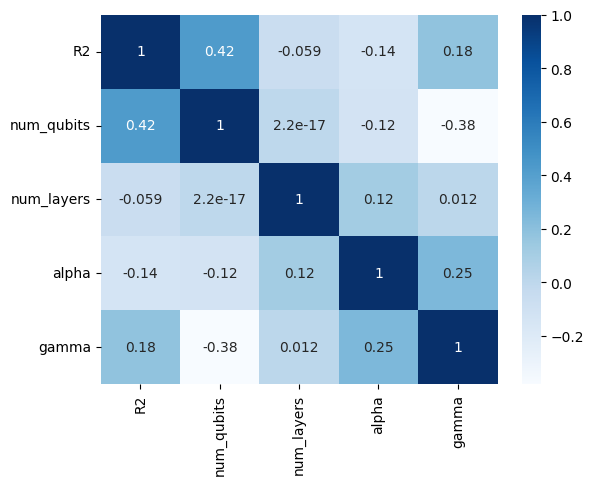

In [17]:
sb.heatmap(df_new, cmap="Blues", annot=True)

A more sophisticated way to study correlations may be based on using Fisher's z-transformation to preserve negative correlations. However, this is beyond the scope of this demonstrator.

By generating a larger experimental database with corresponding QKMOptuna.evaluate_grid() simulation results we aim at answering the question (numerically) to which extent all the quantum kernel methods hyperparameters are correlated w.r.t given performance metrics.

### Comments

At this, let us remark that QKMOptuna also alows for performing KTA within the pipeline using any or only the optimal cached result.

Moreover we note, that in this demonstrator we did not make full use of the QKMOptuna pipeline's full functionality. As such, the following is missing:

- Investigation and optimization of preprocessing routines (MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler(), PowerTransformer() and Bandwidth-Scaling implemented)
- Systematic comparison of QSVR vs. QKRR
- Application to classification problems (QSVC implemented)
- Use of more encoding circuits to enlarge data foundation and improve statistics
- shot-based simulations

## Outlook

We will use our sQUlearn quantum kernel engine as well as the QKMOptuna hyperparameter optimization pipeline to perform an extensive hyperparameter and benchmark study to address the following open questions (for sufficiently complex regression/classification datasets) for quantum kernel methods:

- Correlations between classical (e.g., regularization, outer_kernel) and quantum (num_qubits, num_layers, bandwidth-tuning, $k$-RDM, measurement operator) hyperparameters and model performance
- Connection to expressibility and entangling capability of corresponding data encoding circuits
- Connection to dataset complexity
- Effect of optimizing trainable parameters via KTA
- shot-based simulations

=> *Corresponding publication in preparation*

## *References*

[1] [M. Schuld, "Supervised quantum machine learning models are kernel methods." arXiv:2101.11020v2 (2021)](https://arxiv.org/abs/2101.11020v2)

[2] [S. Thanasilp, S. Wang, M. Cerezo, Z. Holmes, "Exponential concentration in quantum kernel methods." arXiv:2208.11060v2 (2024)](https://arxiv.org/abs/2208.11060)

[3] [H.-Y. Huang, M. Broughton, M. Mohseni, R. Babbush, S. Boixo, H. Neven., J. R. McClean, "Power of data in quantum machine learning." Nat. Commun. 12, 2631 (2021)](https://www.nature.com/articles/s41467-021-22539-9)

[4] [D. A. Kreplin, M. Willmann, J. Schnabel, F. Rapp, M. Hagelüken, M. Roth, "sQUlearn -- A Python Library for Quantum Machine Learning." arXiv:2311.08990v2 (2024)](https://arxiv.org/abs/2311.08990)

[5] [J. Bowles, S. Ahmed, M. Schuld, "Better than classical? The subtle art of benchmarking quantum machine learning models". arXiv:2403.07059v2 (2024)](https://arxiv.org/abs/2403.07059)